# Text Classification with BERT

This project aims to use **BERT** to perform **text classification**.

We'll be using the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) (SST-2) dataset of movie reviews and a smaller version of BERT - [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) - developed by HuggingFace. Our goal is to classify our moview reviews as positive or negative.

We'll start by loading and checking the data.

### Step 1

#### 1. Perform initial imports

In [1]:
import numpy as np
import pandas as pd
import os

from torchtext import data, datasets

from collections import Counter

#### 2. Load data

In [2]:
# sequential=False since we don't want to tokenize the text
# lowercased text
text_data = data.Field(sequential=False, lower=True)

label_data = data.Field(sequential=False)

In [3]:
train, dev, test = datasets.SST.splits(text_data, label_data)

#### 3. Check data

In [4]:
# check train fields

train.fields

{'text': <torchtext.data.field.Field at 0x2c6849ceca0>,
 'label': <torchtext.data.field.Field at 0x2c6849cee50>}

In [5]:
# check first review

train[0].text

"the rock is destined to be the 21st century 's new `` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal ."

In [6]:
# check first label

train[0].label

'positive'

In [7]:
len(train)

8544

In [8]:
# function to count the number of reviews with any given label

def label_count(sst_data):
    
    labels = []

    for i in range(len(sst_data)):
        labels.append(sst_data[i].label)
        
    counts = Counter(labels)
    
    return counts

In [9]:
label_count(train)

Counter({'positive': 3610, 'neutral': 1624, 'negative': 3310})

We have 8544 moview reviews in total. From these, **3610** are classified as **positive**, 1624 as neutral and **3310** as **negative**.

Since we intend to use the **SST-2 dataset (binary classification)**, we are only interested in the reviews classified as positive or negative.

In [10]:
train, dev, test = datasets.SST.splits(text_data, label_data, 
                                       filter_pred=lambda x: x.label != 'neutral')

In [11]:
label_count(train)

Counter({'positive': 3610, 'negative': 3310})

We have **6920 moview reviews: 3610 are labeled as positive and 3310 are labeled as negative**. Our data is now correctly loaded and we can proceed with our project.

#### 4. Create a dataframe and select a subset of our data

In [12]:
train_data = []

for i in range(len(train)):
    data = {}
    data['review']=train[i].text
    data['label']=train[i].label
    train_data.append(data)

In [13]:
train_data[0]

{'review': "the rock is destined to be the 21st century 's new `` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",
 'label': 'positive'}

In [14]:
df_train = pd.DataFrame(train_data)

In [15]:
df_train.head()

,review,label
0,the rock is destined to be the 21st century 's...,positive
1,the gorgeously elaborate continuation of `` th...,positive
2,singer\/composer bryan adams contributes a sle...,positive
3,yet the act is still charming here .,positive
4,whether or not you 're enlightened by any of d...,positive


In [16]:
len(df_train)

6920

In [17]:
# check number of both labels

df_train['label'].value_counts()

positive    3610
negative    3310
Name: label, dtype: int64

We can also save our dataframe as a `.tsv` file for later use.

In [18]:
# create folder if it does not exist

output_dir = './.data/sst/tsv'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [19]:
# save df_train as a .tsv file

df_train.to_csv('./.data/sst/tsv/train.tsv', sep='\t', index=False)

For performance reasons, we'll be using only **half of the training dataset** for our text classification task.

In [18]:
df = df_train.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [19]:
df.head(10)

,review,label
0,e.t. works because its flabbergasting principa...,positive
1,"from the dull , surreal ache of mortal awarene...",positive
2,a disoriented but occasionally disarming saga ...,positive
3,the only type of lives this glossy comedy-dram...,negative
4,"in the affable maid in manhattan , jennifer lo...",positive
5,"a must for fans of british cinema , if only be...",positive
6,earnest and heartfelt but undernourished and p...,positive
7,"` anyone with a passion for cinema , and indee...",positive
8,"we never feel anything for these characters , ...",negative
9,- style cross-country adventure ... it has spo...,positive


In [20]:
len(df)

3460

In [21]:
df['label'].value_counts()

positive    1849
negative    1611
Name: label, dtype: int64

We now have 3460 reviews, from which 1849 are positive and 1611 are negative.

In [22]:
# length of longest review

max([len(review.split()) for review in df['review']])

52

In [23]:
# average length of the reviews

np.rint(np.mean([len(review.split()) for review in df['review']]))

19.0

Our reviews have an **average length of 19 words** and the **longest review has 52 words**.

We can now use **DistilBERT to tokenize our reviews**. This will be our **step 2**.

### Step 2

#### 1. Perform necessary imports

In [24]:
import torch
import transformers as pytt

#### 2. Load pretrained model

In [25]:
# using DistilBERT
model_class, tokenizer_class, pretrained_weights = (pytt.DistilBertModel, pytt.DistilBertTokenizer, 'distilbert-base-uncased')

# load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

We'll be using the **DistilBERT model**, more specifically the [distilbert-base-uncased model](https://huggingface.co/transformers/pretrained_models.html), trained on lower-cased English text since our reviews are also lower-cased.

We are now ready to tokenize our reviews. Besides tokenization, we'll also perform padding so that our reviews have all the same length.

#### 3. Tokenize and padd reviews

In [26]:
# max_length=70 should be enough for all tokens, including special tokens

df_tokenized_padded = df['review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                              max_length=70, 
                                                              pad_to_max_length=True)))

In [27]:
df_tokenized_padded.head()

0    [101, 1041, 1012, 1056, 1012, 2573, 2138, 2049...
1    [101, 2013, 1996, 10634, 1010, 16524, 12336, 1...
2    [101, 1037, 4487, 21748, 25099, 2094, 2021, 56...
3    [101, 1996, 2069, 2828, 1997, 3268, 2023, 1950...
4    [101, 1999, 1996, 21358, 7011, 3468, 10850, 19...
Name: review, dtype: object

In [28]:
df_tokenized_padded[0]

[101,
 1041,
 1012,
 1056,
 1012,
 2573,
 2138,
 2049,
 13109,
 7875,
 4059,
 14083,
 2075,
 27928,
 1010,
 2403,
 1011,
 2095,
 1011,
 2214,
 2728,
 6097,
 2532,
 18533,
 2239,
 1010,
 1020,
 1011,
 2095,
 1011,
 2214,
 3881,
 6287,
 5974,
 1998,
 2184,
 1011,
 2095,
 1011,
 2214,
 2888,
 2726,
 1010,
 8054,
 2149,
 1997,
 1996,
 4598,
 1997,
 1996,
 7968,
 1010,
 15536,
 10431,
 2098,
 10367,
 2013,
 1037,
 2521,
 9497,
 4774,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [29]:
len(df_tokenized_padded[0])

70

Our reviews are now tokenized and include special tokens like the **\[CLS\]** token - id 101 - at the beginning of each review and the **\[SEP\]** token - id 102 - at the end. Note that each token was replaced by its corresponding id from the embedding table of the pretrained model we loaded.

The reviews have also been padded with 0's so that they all have the same length.

#### 4. Get reviews in the correct shape

In [30]:
df_tokenized_padded.shape

(3460,)

In [31]:
len(df_tokenized_padded.shape)

1

Our reviews are stored as a one dimensional tensor (a vector) with 3460 rows, but we need a two dimensional tensor (a matrix).

In [32]:
arr_reviews = np.array([review for review in df_tokenized_padded.values])

In [33]:
arr_reviews

array([[  101,  1041,  1012, ...,     0,     0,     0],
       [  101,  2013,  1996, ...,     0,     0,     0],
       [  101,  1037,  4487, ...,     0,     0,     0],
       ...,
       [  101,  2035,  1996, ...,     0,     0,     0],
       [  101,  1037, 20161, ...,     0,     0,     0],
       [  101,  1996,  4164, ...,     0,     0,     0]])

In [34]:
arr_reviews.shape

(3460, 70)

We now need to create a mask in order for our model to be able distinguish the padding from the rest of the tokens.

#### 5. Create attention mask

In [35]:
arr_attention_mask = np.where(arr_reviews != 0, 1, 0)

In [36]:
arr_attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [37]:
arr_attention_mask.shape

(3460, 70)

We now have everything we need to **feed the reviews to our DistilBERT model** - this is our **step 3**.

### Step 3

#### 1. Create torch tensors

In [38]:
input_ids = torch.tensor(arr_reviews, dtype=torch.int64) # a long tensor is expected
attention_mask = torch.tensor(arr_attention_mask, dtype=torch.int64) # a long tensor is expected
# PyTorch data types: https://pytorch.org/docs/stable/tensor_attributes.html

#### 2. Feed reviews to DistilBERT

In [39]:
%%time

# disabling gradient calculation
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Wall time: 3min 41s


In [40]:
type(last_hidden_states)

tuple

In [41]:
len(last_hidden_states)

1

In [42]:
last_hidden_states[0].shape

torch.Size([3460, 70, 768])

Our output is a one dimensional tuple. It stores a torch tensor of shape **(number of reviews, length of padded reviews, number of hidden units of our DistilBERT model)**.

We are interested in the **output for the \[CLS\] token only** since we are dealing with a classification task. Let's slice our output.

#### 3. Slice output

We want to keep the output for all our reviews, but only what corresponds to the first token (the \[CLS\] token) of each one. We also want to keep the output of all the hidden units, i. e., the slice `[:, 0, :]`.

In [43]:
reviews_BERT = last_hidden_states[0][:, 0, :].numpy()

In [44]:
reviews_BERT.shape

(3460, 768)

We now have a 2D numpy array with the desired embeddings for each review.

To train our classifier, we only need to check our labels and we are good to go!

#### 4. Check labels

In [45]:
labels = df['label']

In [46]:
labels.shape

(3460,)

The labels for our 3460 reviews are stored in the variable `labels`. We can proceed to our **step 4 and train our classifier**.

### Step 4

#### 1. Perform necessary imports

In [47]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt

#### 2. Split train and test data

In [48]:
X_train, X_test, y_train, y_test = train_test_split(reviews_BERT, labels, test_size = 0.3, random_state = 42)

In [49]:
X_train.shape

(2422, 768)

In [50]:
X_test.shape

(1038, 768)

We'll use 2422 reviews to train our classifier and 1038 to test it.

#### 3. Create model and train it

In [51]:
review_clf = LogisticRegression(max_iter=1000)

review_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### 4. Make predictions

In [52]:
predictions = review_clf.predict(X_test)

In [53]:
predictions[0:10]

array(['negative', 'negative', 'positive', 'positive', 'negative',
       'positive', 'negative', 'positive', 'positive', 'positive'],
      dtype=object)

Our classifier seems to be working correctly. It's now time to evaluate it.

#### 5. Evaluate model

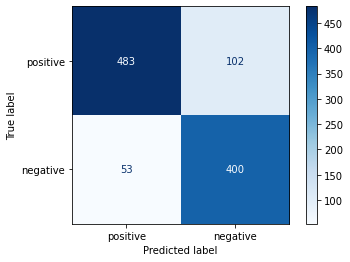

In [54]:
# plot confusion matrix

plot_confusion_matrix(review_clf, X_test, y_test, 
                      labels=sorted(review_clf.classes_, reverse=True), # to have positive first
                      values_format='.3g',
                      cmap=plt.cm.Blues);

Our plot confirms our previous idea. The **true positives (left upper corner)** and **true negatives (right lower corner)** clearly dominate our predictions.

With these values we can calculate both the **precision and recall** of our classifier. These two metrics can then be combined to calculate the **f1-score**, which represents an equal tradeoff between precision and recall.

In [55]:
# precision, recall and f1-score

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.80      0.88      0.84       453
    positive       0.90      0.83      0.86       585

    accuracy                           0.85      1038
   macro avg       0.85      0.85      0.85      1038
weighted avg       0.86      0.85      0.85      1038



Our precision and recall are quite similar, and so is our f1-score. Since our dataset is almost evenly balanced, a metric like **accuracy** can also be used to properly evaluate our model.

In [56]:
# accuracy

print(accuracy_score(y_test, predictions))

0.850674373795761


We get a final **accuracy of 85,1%**, which is a very interesting result considering the overall simplicity of our approach.

For comparison, in the paper [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/pdf/1910.01108v4.pdf), DistilBERT achieves an **accuray score of 91.3%** and the highest score to date (May 7, 2020) for this dataset is achieved by T5-3B: **97,4% accuracy**!! You can check [this page](https://paperswithcode.com/sota/sentiment-analysis-on-sst-2-binary) for the current state-of-the-art results with the SST-2 dataset.

This project was based on Jay Alammar's blog post, [A Visual Guide to Using BERT for the First Time](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/). Please check it out if you want to know more.